# Building deep neural network

> ## Sign Language Digits Dataset

#### Sign languages (also known as signed languages) are languages that use manual communication to convey meaning. This can include simultaneously employing hand gestures, movement, orientation of the fingers, arms or body, and facial expressions to convey a speaker's ideas.

## 1 - Packages ##

Let’s first import all the packages that you will need during this assignment.

- numpy is the main package for scientific computing with Python.

- matplotlib is a library to plot graphs in Python.

- dnn_utils provides some necessary functions for this notebook.

- testCases provides some test cases to assess the correctness of your functions

- np.random.seed(1) is used to keep all the random function calls consistent. 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
from testCases_v3 import *;
from dnn_utils_v2 import sigmoid, sigmoid_backward, relu, relu_backward;
%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = (5.0, 4.0); # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest';
plt.rcParams['image.cmap'] = 'gray';
%load_ext autoreload
%autoreload 2
np.random.seed(1);

## 2 - Overview of the Problem set ##
Details of datasets:

In this data there are 2062 sign language digits images.

Image size: 64x64

Color space: Grayscale

File format: npy

Number of classes: 10 (Digits: 0-9)

Number of participant students: 218

Number of samples per student: 10



### Loading Dataset

(-0.5, 63.5, 63.5, -0.5)

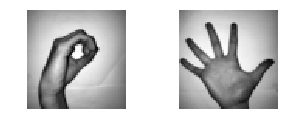

In [4]:
x_l = np.load('C:\\Users\\Admin\\Desktop\\internship_course\\SELF\\X.npy')
Y_l = np.load('C:\\Users\\Admin\\Desktop\\internship_course\\SELF\\Y.npy')
img_size = 64
plt.subplot(2, 2, 1)
plt.imshow(x_l[260].reshape(img_size, img_size))
plt.axis('off')
plt.subplot(2, 2, 2)
plt.imshow(x_l[2000].reshape(img_size, img_size))
plt.axis('off')


## Forward Propagation

### Helper Functions

We need to compute : $sigmoid( w^T x + b) = \frac{1}{1 + e^{-(w^T x + b)}}$

In [5]:
def sigmoid(Z):
 """
 Implements the sigmoid activation in numpy
 Arguments:
 Z -- numpy array of any shape
 Returns:
 A -- output of sigmoid(z), same shape as Z
 cache -- returns Z as well, useful during backpropagation
 """
 A = 1 / (1 + np.exp(-Z));
 cache = Z;
 return A, cache;

In [6]:
def sigmoid_backward(dA, cache):
 """
 Implement the backward propagation for a single SIGMOID unit.
 Arguments:
 dA -- post-activation gradient, of any shape
 cache -- 'Z' where we store for computing backward propagation efficiently
 Returns:
 dZ -- Gradient of the cost with respect to Z
 """
 Z = cache;
 s = 1 / (1 + np.exp(-Z));
 dZ = dA * s * (1 - s);
 assert (dZ.shape == Z.shape);
 return dZ;


In [7]:
def relu(Z):
 """
 Implement the RELU function.
 Arguments:
 Z -- Output of the linear layer, of any shape
 Returns:
 A -- Post-activation parameter, of the same shape as Z
 cache -- a python dictionary containing "A" ; stored for computing the backward pass effic
 """
 A = np.maximum(0,Z);
 assert(A.shape == Z.shape);
 cache = Z;
 return A, cache;

In [7]:
def relu_backward(dA, cache):
 """
 Implement the backward propagation for a single RELU unit.
 Arguments:
 dA -- post-activation gradient, of any shape
 cache -- 'Z' where we store for computing backward propagation efficiently
 Returns:
 dZ -- Gradient of the cost with respect to Z
 """
 Z = cache;
 dZ = np.array(dA, copy = True); # just converting dz to a correct object.
 # When z <= 0, you should set dz to 0 as well.
 dZ[Z <= 0] = 0;
 assert (dZ.shape == Z.shape);
 return dZ;


In [8]:
# Join a sequence of arrays along an row axis.
X = np.concatenate((x_l[204:409], x_l[822:1027] ), axis=0) # from 0 to 204 is zero sign and from 205 to 410 is one sign 
z = np.zeros(205)
o = np.ones(205)
Y = np.concatenate((z, o), axis=0).reshape(X.shape[0],1)
print("X shape: " , X.shape)
print("Y shape: " , Y.shape)

X shape:  (410, 64, 64)
Y shape:  (410, 1)


In [9]:
# Then lets create x_train, y_train, x_test, y_test arrays
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42)
number_of_train = X_train.shape[0]
number_of_test = X_test.shape[0]

In [10]:
X_train_flatten = X_train.reshape(number_of_train,X_train.shape[1]*X_train.shape[2])
X_test_flatten = X_test .reshape(number_of_test,X_test.shape[1]*X_test.shape[2])
print("X train flatten",X_train_flatten.shape)
print("X test flatten",X_test_flatten.shape)

X train flatten (348, 4096)
X test flatten (62, 4096)


In [11]:
x_train = X_train_flatten.T
x_test = X_test_flatten.T
y_train = Y_train.T
y_test = Y_test.T
print("x train: ",x_train.shape)
print("x test: ",x_test.shape)
print("y train: ",y_train.shape)
print("y test: ",y_test.shape)

x train:  (4096, 348)
x test:  (4096, 62)
y train:  (1, 348)
y test:  (1, 62)


**Layer Size and Weights and Bias Initialization** <BR>
In x_train, there are 348 images x^(348)<BR>
To obtain variety, we should initialize weights randomly; but as small number like 0.01. <br>
We should initialize weights as small number since when we use tanh activation function with big value weights, its derivative is approximetly 0 and we cannot generate optimistic result. (ex.: tanh(5) ~= 0.999 and Its derivative is ~ 0).
However we can initialize bias as zero.
I prefer to use 3 nodes hidden layer when implementing 2 layer ANN. Because of this reason:
 * Shape of weight1 :  (3, 4096)
 * Shape of weight2 :  (1, 3)
 * Shape of bias1 :  (3, 1)
 * Shape of bias2 :  (1, 1)

In [12]:
def parameter_initialize(x_train,y_train):
    parameters = {"weight1": np.random.randn(3,x_train.shape[0])*0.1,
                  "bias1": np.zeros((3,1)),
                  "weight2": np.random.randn(y_train.shape[0],3)*0.1,
                  "bias2" : np.zeros((y_train.shape[0],1))}
    
    print("Shape of weight1 : ",parameters["weight1"].shape)
    print("Shape of weight2 : ",parameters["weight2"].shape)
    print("Shape of bias1 : ",parameters["bias1"].shape)
    print("Shape of bias2 : ",parameters["bias2"].shape)

    return parameters
parameter_initialize(x_train,y_train)

Shape of weight1 :  (3, 4096)
Shape of weight2 :  (1, 3)
Shape of bias1 :  (3, 1)
Shape of bias2 :  (1, 1)


{'weight1': array([[ 0.16243454, -0.06117564, -0.05281718, ..., -0.14788339,
         -0.04929046,  0.07949473],
        [-0.10922135,  0.20865146,  0.1316653 , ..., -0.06137821,
          0.13543076,  0.05320339],
        [-0.06501626,  0.22848077, -0.0540921 , ..., -0.05272142,
         -0.03803397,  0.09494124]]), 'bias1': array([[0.],
        [0.],
        [0.]]), 'weight2': array([[ 0.10092311,  0.0229889 , -0.06640991]]), 'bias2': array([[0.]])}

**Forward Propagation**<br>
In this part we use two different activation functions which are sigmoid and tanh.
Firstly, we should initialize sigmoid function and for tanh function we use numpy library.

In [13]:
def sigmoid(z):
    A = 1/(1+np.exp(-z))
    return A


In [14]:
def forward_propagation(x_train,parameters):
    Z1 = np.dot(parameters["weight1"],x_train) + parameters["bias1"]
    A1 = np.tanh(Z1)
    Z2 = np.dot(parameters["weight2"],A1) + parameters["bias2"]
    A2 = sigmoid(Z2)
    
    results = {"Z1": Z1, "A1":A1,"Z2":Z2,"A2":A2}
    return A2, results

In [15]:
def cost(A2,Y):
    logaritmic_probability = np.multiply(np.log(A2),Y)
    cost = -np.sum(logaritmic_probability)/Y.shape[1]
    return cost

**Backward Propagation** <BR>
 In this part, we take derivative of weights, for weight1 and weight2, bais, for bais1 and bais2, results, for Z1 and Z2 according to cost.

In [16]:
def backward_propagation(parameters,results,X,Y):
    dZ2 = results["A2"]-Y
    dW2 = np.dot(dZ2,results["A1"].T)/X.shape[1]
    db2 = np.sum(dZ2, axis = 1, keepdims = True)/X.shape[1]
    dZ1 = np.dot(parameters["weight2"].T,dZ2)*(1-np.power(results["A1"],2))
    dW1 = np.dot(dZ1,X.T)/X.shape[1]
    db1 = np.sum(dZ1, axis=1,keepdims = True)/X.shape[1]
    gradients = {"dweight1": dW1,
                "dweight2": dW2,
                "dbias1": db1,
                "dbias2":db2}
    return gradients

**Update Parameters**

In [17]:
def update_prameters(parameters,grand,learning_rate = 0.01):
    parameters = {"weight1": parameters["weight1"]-learning_rate*grand["dweight1"],
                  "bias1": parameters["bias1"]-learning_rate*grand["dbias1"],
                  "weight2": parameters["weight2"]-learning_rate*grand["dweight2"],
                  "bias2" : parameters["bias2"]-learning_rate*grand["dbias2"]
                 }
    return parameters

**Prediction**

In [18]:
def prediction(parameters, x_test):
    A2, results = forward_propagation(x_test,parameters)
    prediction = np.zeros((1,x_test.shape[1]))
    
    for i in range(A2.shape[1]):
        if A2[0,i] <= 0.5:
            prediction[0,i] = 0
        else:
            prediction[0,i] = 1
    return prediction

# 2 Layer ANN Model Implementation


Shape of weight1 :  (3, 4096)
Shape of weight2 :  (1, 3)
Shape of bias1 :  (3, 1)
Shape of bias2 :  (1, 1)
Cost after iteration 0 0.342632
Cost after iteration 100 0.316843
Cost after iteration 200 0.278211
Cost after iteration 300 0.222048
Cost after iteration 400 0.171436
Cost after iteration 500 0.135530
Cost after iteration 600 0.111432
Cost after iteration 700 0.094889
Cost after iteration 800 0.082982
Cost after iteration 900 0.073971
Cost after iteration 1000 0.066836
Cost after iteration 1100 0.060947
Cost after iteration 1200 0.055879
Cost after iteration 1300 0.051316
Cost after iteration 1400 0.047013
Cost after iteration 1500 0.042827
Cost after iteration 1600 0.038785
Cost after iteration 1700 0.034991
Cost after iteration 1800 0.031447
Cost after iteration 1900 0.028107


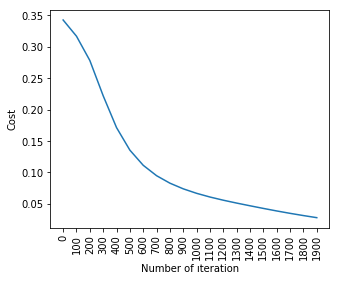

train accuracy: 99.42528735632185 %
test accuracy: 96.7741935483871 %


In [19]:
def two_layer_ANN_model(x_train, y_train, x_test, y_test, number_of_iteration):
    cost_list = []
    index = []
    parameters = parameter_initialize(x_train,y_train)
    for i in range(number_of_iteration):
        A2, results = forward_propagation(x_train,parameters)
        cost_result = cost(A2,y_train)
        gradients = backward_propagation(parameters,results,x_train,y_train)
        parameters = update_prameters(parameters, gradients)
        
        if i % 100 == 0:
            cost_list.append(cost_result)
            index.append(i)
            print("Cost after iteration %i %f" %(i,cost_result))
    plt.plot(index,cost_list)
    plt.xticks(index,rotation='vertical')
    plt.xlabel("Number of ıteration")
    plt.ylabel("Cost")
    plt.show()
    y_prediction_test = prediction(parameters,x_test)
    y_prediction_train = prediction(parameters,x_train)
    print("train accuracy: {} %".format(100 - np.mean(np.abs(y_prediction_train - y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(y_prediction_test - y_test)) * 100))
    return parameters
parameters = two_layer_ANN_model(x_train,y_train,x_test,y_test,2000)


In [21]:
def sigmoid(Z):
 """
 Implements the sigmoid activation in numpy
 Arguments:
 Z -- numpy array of any shape
 Returns:
 A -- output of sigmoid(z), same shape as Z
 cache -- returns Z as well, useful during backpropagation
 """
 A = 1 / (1 + np.exp(-Z));
 cache = Z;
 return A, cache;

# L-layer Neural Network

In [23]:
# GRADED FUNCTION: initialize_parameters_deep

def initialize_parameters_deep(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
       
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
       
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

In [24]:
parameters = initialize_parameters_deep([5,4,3])
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[ 0.01788628  0.0043651   0.00096497 -0.01863493 -0.00277388]
 [-0.00354759 -0.00082741 -0.00627001 -0.00043818 -0.00477218]
 [-0.01313865  0.00884622  0.00881318  0.01709573  0.00050034]
 [-0.00404677 -0.0054536  -0.01546477  0.00982367 -0.01101068]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[-0.01185047 -0.0020565   0.01486148  0.00236716]
 [-0.01023785 -0.00712993  0.00625245 -0.00160513]
 [-0.00768836 -0.00230031  0.00745056  0.01976111]]
b2 = [[0.]
 [0.]
 [0.]]


4 - Forward propagation module

In [25]:
# GRADED FUNCTION: linear_forward

def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python tuple containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    
    Z = np.dot(W,A) + b
   
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

In [28]:
A, activation_cache = sigmoid(Z);

In [29]:
A, activation_cache = relu(Z);

In [30]:
# GRADED FUNCTION: linear_activation_forward

def linear_activation_forward(A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python tuple containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    
    if activation == "sigmoid":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
     
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
        
    elif activation == "relu":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
     
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

**L layered**

In [33]:
# GRADED FUNCTION: L_model_forward

def L_model_forward(X, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_activation_forward() (there are L-1 of them, indexed from 0 to L-1)
    """

    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A 
       
        W = parameters['W' + str(l)]
        b = parameters['b' + str(l)]
        A, cache = linear_activation_forward(A_prev, W, b, activation = "relu")
        caches.append(cache)
        
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
   
    W = parameters['W' + str(L)]
    b = parameters['b' + str(L)]
    AL, cache = linear_activation_forward(A, W, b, activation = "sigmoid")
    caches.append(cache)
    
    assert(AL.shape == (1,X.shape[1]))
            
    return AL, caches

**compute cost**

In [37]:
# GRADED FUNCTION: compute_cost

def compute_cost(AL, Y):
    """
    Implement the cost function defined by equation (7).

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    
    m = Y.shape[1]

    # Compute loss from aL and y.
    ### START CODE HERE ### (≈ 1 lines of code)
    cost = (-1/m) * (np.dot(Y, np.log(AL).T) + np.dot((1-Y), np.log(1-AL).T))
    ### END CODE HERE ###
    
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())
    
    return cost

In [38]:
def compute_cost_test_case():
    Y = np.asarray([[1, 1, 1]]);
    aL = np.array([[.8,.9,0.4]]);
    return Y, aL;


In [39]:
Y, AL = compute_cost_test_case()

print("cost = " + str(compute_cost(AL, Y)))

cost = 0.41493159961539694


In [40]:
def relu_backward(dA, cache):
 """
 Implement the backward propagation for a single RELU unit.
 Arguments:
 dA -- post-activation gradient, of any shape
 cache -- 'Z' where we store for computing backward propagation efficiently
 Returns:
 dZ -- Gradient of the cost with respect to Z
 """
 Z = cache;
 dZ = np.array(dA, copy = True); # just converting dz to a correct object.
 # When z <= 0, you should set dz to 0 as well.
 dZ[Z <= 0] = 0;
 assert (dZ.shape == Z.shape);
 return dZ;


In [41]:
# GRADED FUNCTION: linear_backward

def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    ### START CODE HERE ### (≈ 3 lines of code)
    dW = (1/m) * np.dot(dZ, A_prev.T)
    db = (1/m) * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)
    ### END CODE HERE ###
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

In [44]:
# GRADED FUNCTION: linear_activation_backward

def linear_activation_backward(dA, cache, activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        ### START CODE HERE ### (≈ 2 lines of code)
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        ### END CODE HERE ###
        
    elif activation == "sigmoid":
        ### START CODE HERE ### (≈ 2 lines of code)
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        ### END CODE HERE ###
    
    return dA_prev, dW, db

In [47]:
# GRADED FUNCTION: L_model_backward

def L_model_backward(AL, Y, caches):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (it's caches[l], for l in range(L-1) i.e l = 0...L-2)
                the cache of linear_activation_forward() with "sigmoid" (it's caches[L-1])
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    ### START CODE HERE ### (1 line of code)
    print("L = "+str(L))
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    ### END CODE HERE ###
    
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "dAL, current_cache". Outputs: "grads["dAL-1"], grads["dWL"], grads["dbL"]
    ### START CODE HERE ### (approx. 2 lines)
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "sigmoid")
    print("dA"+ str(L-1)+" = "+str(grads["dA" + str(L-1)]))
    print("dW"+ str(L)+" = "+str(grads["dW" + str(L)]))
    print("db"+ str(L)+" = "+str(grads["db" + str(L)]))
    
    ### END CODE HERE ###
    
    # Loop from l=L-2 to l=0
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        # Inputs: "grads["dA" + str(l + 1)], current_cache". Outputs: "grads["dA" + str(l)] , grads["dW" + str(l + 1)] , grads["db" + str(l + 1)] 
        ### START CODE HERE ### (approx. 5 lines)
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation = "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
        ### END CODE HERE ###

    return grads

**update parameters**

In [50]:
# GRADED FUNCTION: update_parameters

def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
    
    return parameters

train accuracy: 98.4 % <BR>
test accuracy: 95.7 %

Congrats on implementing all the functions required for building a deep neural network!